# Latent Diffusion Model 高质量图像生成 Demo

本 notebook 展示几种不同的 diffusion model 生成方法，对比质量差异。

## 0. 环境检查

In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5050 Laptop GPU
GPU Memory: 8.5 GB


In [2]:
# 安装依赖 (如果需要)
# !pip install diffusers transformers accelerate -q

---
## 方案 1: Pixel-Space DDPM (质量最好，但较慢)

这是在像素空间直接做 diffusion，没有 VAE 压缩带来的信息损失，质量通常最好。

In [3]:
from diffusers import DDPMPipeline
import matplotlib.pyplot as plt
import time

print("加载 google/ddpm-celebahq-256 (像素空间 DDPM)...")
ddpm_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
ddpm_pipe = ddpm_pipe.to("cuda")
print("✓ 模型加载完成!")

加载 google/ddpm-celebahq-256 (像素空间 DDPM)...


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

c:\Users\xyc93\miniconda3\envs\torch\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\xyc93\.cache\huggingface\hub\models--google--ddpm-celebahq-256. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\xyc93\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\xyc93\.cache\huggingface\hub\models--google--ddpm-celebahq-256\snapshots\cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


✓ 模型加载完成!


In [4]:
# 生成 4 张图片 (像素空间 DDPM 需要较多步数)
print("生成 4 张图片 (1000 steps, 需要几分钟)...")

start_time = time.time()
ddpm_images = []

for i in range(4):
    print(f"  生成第 {i+1}/4 张...")
    result = ddpm_pipe(num_inference_steps=1000)
    ddpm_images.append(result.images[0])

elapsed = time.time() - start_time
print(f"\n✓ 完成! 总耗时: {elapsed:.1f}s, 平均每张: {elapsed/4:.1f}s")

生成 4 张图片 (1000 steps, 需要几分钟)...
  生成第 1/4 张...


  0%|          | 0/1000 [00:00<?, ?it/s]

  生成第 2/4 张...


  0%|          | 0/1000 [00:00<?, ?it/s]

  生成第 3/4 张...


  0%|          | 0/1000 [00:00<?, ?it/s]

  生成第 4/4 张...


  0%|          | 0/1000 [00:00<?, ?it/s]


✓ 完成! 总耗时: 463.4s, 平均每张: 115.8s


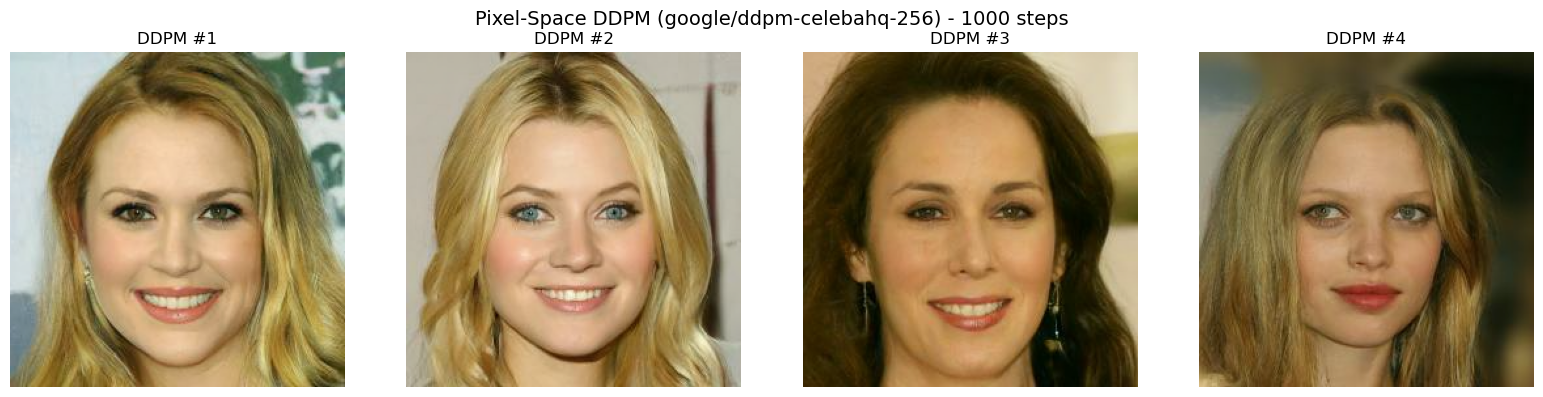

In [5]:
# 可视化
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, img in enumerate(ddpm_images):
    axes[i].imshow(img)
    axes[i].set_title(f"DDPM #{i+1}")
    axes[i].axis('off')
plt.suptitle("Pixel-Space DDPM (google/ddpm-celebahq-256) - 1000 steps", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
# 清理显存
del ddpm_pipe
torch.cuda.empty_cache()
print("显存已清理")

显存已清理


---
## 方案 2: Stable Diffusion (LDM, 文本条件生成)

这是 Latent Diffusion Model 的代表作，使用高质量 KL-VAE，生成质量很好。

In [7]:
from diffusers import StableDiffusionPipeline

print("加载 Stable Diffusion v1.5...")
sd_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,  # 使用 fp16 节省显存
    safety_checker=None,
    requires_safety_checker=False
)
sd_pipe = sd_pipe.to("cuda")
print("✓ 模型加载完成!")

加载 Stable Diffusion v1.5...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


✓ 模型加载完成!


In [8]:
# 生成人脸图片
prompts = [
    "a professional portrait photo of a young woman, natural lighting, high quality, detailed face",
    "a professional portrait photo of a middle-aged man with glasses, studio lighting, sharp focus",
    "a portrait photo of an elderly woman smiling, warm lighting, high resolution",
    "a portrait photo of a young man, cinematic lighting, detailed skin texture, 8k"
]

print("生成 4 张人脸图片 (50 steps)...")
start_time = time.time()

sd_images = []
for i, prompt in enumerate(prompts):
    print(f"  生成第 {i+1}/4 张: {prompt[:50]}...")
    result = sd_pipe(
        prompt,
        num_inference_steps=50,
        guidance_scale=7.5
    )
    sd_images.append(result.images[0])

elapsed = time.time() - start_time
print(f"\n✓ 完成! 总耗时: {elapsed:.1f}s, 平均每张: {elapsed/4:.1f}s")

生成 4 张人脸图片 (50 steps)...
  生成第 1/4 张: a professional portrait photo of a young woman, na...


  0%|          | 0/50 [00:00<?, ?it/s]

  生成第 2/4 张: a professional portrait photo of a middle-aged man...


  0%|          | 0/50 [00:00<?, ?it/s]

  生成第 3/4 张: a portrait photo of an elderly woman smiling, warm...


  0%|          | 0/50 [00:00<?, ?it/s]

  生成第 4/4 张: a portrait photo of a young man, cinematic lightin...


  0%|          | 0/50 [00:00<?, ?it/s]


✓ 完成! 总耗时: 38.1s, 平均每张: 9.5s


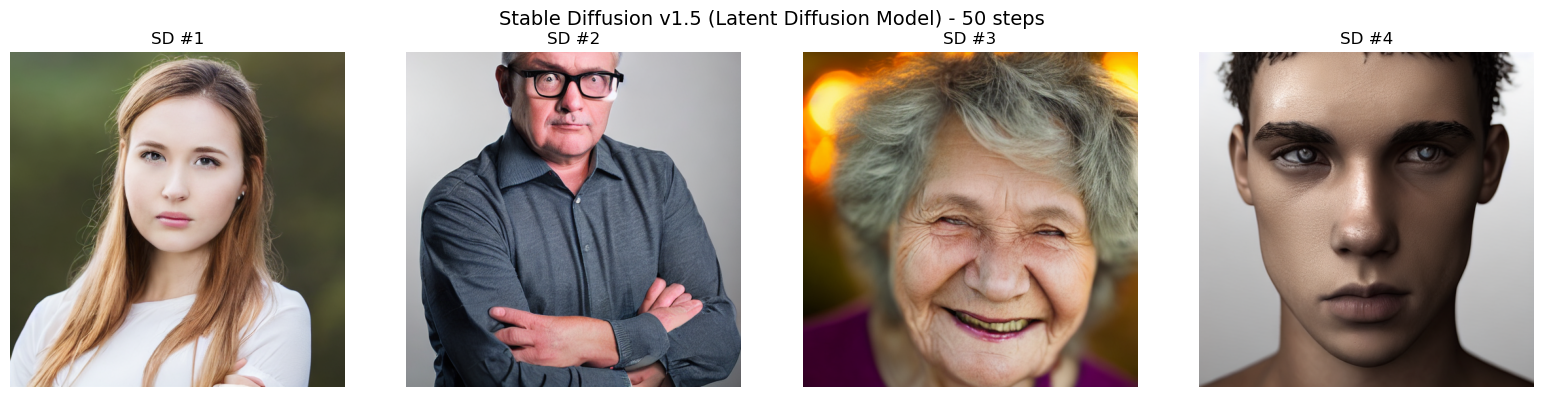

In [9]:
# 可视化
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, img in enumerate(sd_images):
    axes[i].imshow(img)
    axes[i].set_title(f"SD #{i+1}")
    axes[i].axis('off')
plt.suptitle("Stable Diffusion v1.5 (Latent Diffusion Model) - 50 steps", fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# 清理显存
del sd_pipe
torch.cuda.empty_cache()
print("显存已清理")

显存已清理


---
## 方案 3: 原始 LDM CelebA-HQ (对比用)

这就是你之前用的模型，放在这里做对比。

In [11]:
from diffusers import DiffusionPipeline

print("加载 CompVis/ldm-celebahq-256 (原始 LDM)...")
ldm_pipe = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
ldm_pipe = ldm_pipe.to("cuda")
print("✓ 模型加载完成!")

加载 CompVis/ldm-celebahq-256 (原始 LDM)...


model_index.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

c:\Users\xyc93\miniconda3\envs\torch\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\xyc93\.cache\huggingface\hub\models--CompVis--ldm-celebahq-256. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

vqvae/diffusion_pytorch_model.bin:   0%|          | 0.00/221M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
An error occurred while trying to fetch C:\Users\xyc93\.cache\huggingface\hub\models--CompVis--ldm-celebahq-256\snapshots\03978f22272a3c2502da709c3940e227c9714bdd\vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\xyc93\.cache\huggingface\hub\models--CompVis--ldm-celebahq-256\snapshots\03978f22272a3c2502da709c3940e227c9714bdd\vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\xyc93\.cache\huggingface\hub\models--CompVis--ldm-celebahq-256\snapshots\03978f22272a3c2502da709c3940e227c9714bdd\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\xyc93\.cache\huggingface\hub\models--CompVis--ldm-celebahq-256\snapshots\03978f2227

✓ 模型加载完成!


In [12]:
print("生成 4 张图片 (200 steps)...")
start_time = time.time()

ldm_images = []
for i in range(4):
    print(f"  生成第 {i+1}/4 张...")
    result = ldm_pipe(num_inference_steps=200)
    ldm_images.append(result.images[0])

elapsed = time.time() - start_time
print(f"\n✓ 完成! 总耗时: {elapsed:.1f}s, 平均每张: {elapsed/4:.1f}s")

生成 4 张图片 (200 steps)...
  生成第 1/4 张...


  0%|          | 0/200 [00:00<?, ?it/s]

  生成第 2/4 张...


  0%|          | 0/200 [00:00<?, ?it/s]

  生成第 3/4 张...


  0%|          | 0/200 [00:00<?, ?it/s]

  生成第 4/4 张...


  0%|          | 0/200 [00:00<?, ?it/s]


✓ 完成! 总耗时: 52.3s, 平均每张: 13.1s


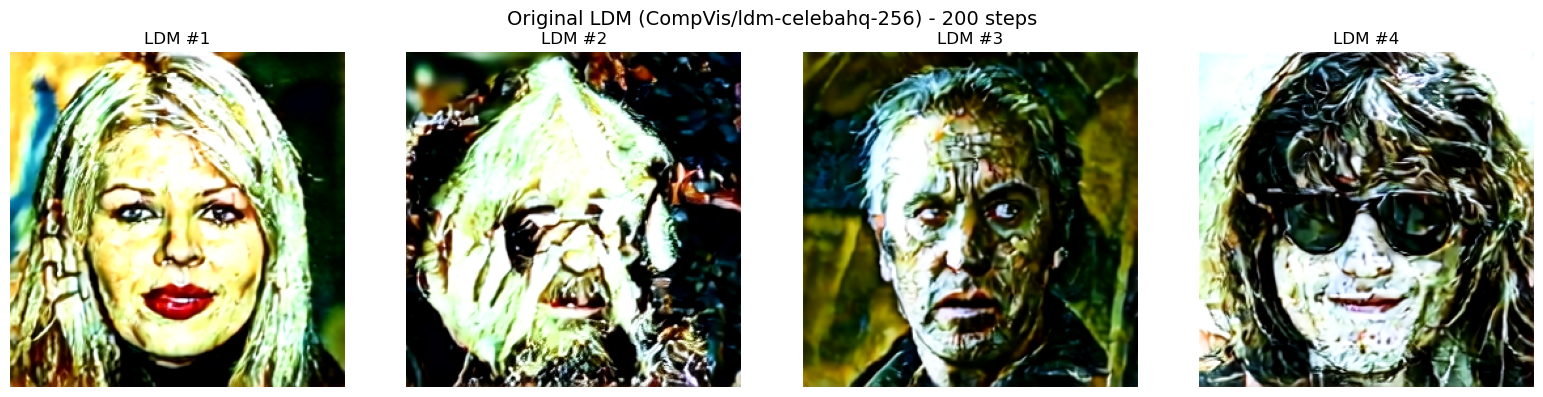

In [13]:
# 可视化
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, img in enumerate(ldm_images):
    axes[i].imshow(img)
    axes[i].set_title(f"LDM #{i+1}")
    axes[i].axis('off')
plt.suptitle("Original LDM (CompVis/ldm-celebahq-256) - 200 steps", fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
# 清理显存
del ldm_pipe
torch.cuda.empty_cache()
print("显存已清理")

显存已清理


---
## 总结对比

| 方法 | 模型 | 空间 | 步数 | 质量 | 速度 |
|------|------|------|------|------|------|
| 方案1 | google/ddpm-celebahq-256 | 像素空间 | 1000 | ⭐⭐⭐⭐⭐ | 慢 |
| 方案2 | Stable Diffusion v1.5 | 潜空间 (KL-VAE) | 50 | ⭐⭐⭐⭐⭐ | 快 |
| 方案3 | CompVis/ldm-celebahq-256 | 潜空间 (VQ-VAE) | 200 | ⭐⭐⭐ | 中等 |

**结论**: 
- 如果要 unconditional 人脸生成，用 **方案1 (DDPM)**
- 如果要高质量快速生成，用 **方案2 (Stable Diffusion)**
- 方案3 的 VQ-VAE 质量有限，不推荐实际使用

---
## 附录: 测试 VQ-VAE 重建质量

验证 CompVis/ldm-celebahq-256 的 VQ-VAE 重建能力。

In [15]:
from diffusers import VQModel
from PIL import Image
import torchvision.transforms as T
import requests
from io import BytesIO

# 加载 VQ-VAE
print("加载 VQ-VAE...")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
vqvae = vqvae.to("cuda")
vqvae.eval()
print("✓ VQ-VAE 加载完成!")

加载 VQ-VAE...


An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


✓ VQ-VAE 加载完成!


In [16]:
# 下载测试图片
url = "https://images.unsplash.com/photo-1544005313-94ddf0286df2?w=256&h=256&fit=crop"
response = requests.get(url)
test_image = Image.open(BytesIO(response.content)).convert("RGB").resize((256, 256))

# 预处理
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 归一化到 [-1, 1]
])
x = transform(test_image).unsqueeze(0).to("cuda")

# 编码 -> 解码
with torch.no_grad():
    latent = vqvae.encode(x).latents
    reconstructed = vqvae.decode(latent).sample

# 后处理
reconstructed = (reconstructed.squeeze().permute(1, 2, 0).cpu().numpy() + 1) / 2
reconstructed = (reconstructed * 255).clip(0, 255).astype('uint8')

print(f"潜空间维度: {latent.shape}")

潜空间维度: torch.Size([1, 3, 64, 64])


C:\Users\xyc93\AppData\Local\Temp\ipykernel_41348\1617733465.py:13: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\xyc93\AppData\Local\Temp\ipykernel_41348\1617733465.py:13: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\xyc93\AppData\Local\Temp\ipykernel_41348\1617733465.py:13: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\xyc93\AppData\Local\Temp\ipykernel_41348\1617733465.py:13: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\xyc93\AppData\Local\Temp\ipykernel_41348\1617733465.py:13: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\xyc93\AppData\Local\Temp\ipykernel_41348\1617733465.py:13: UserWarning: Glyph 35797 (\

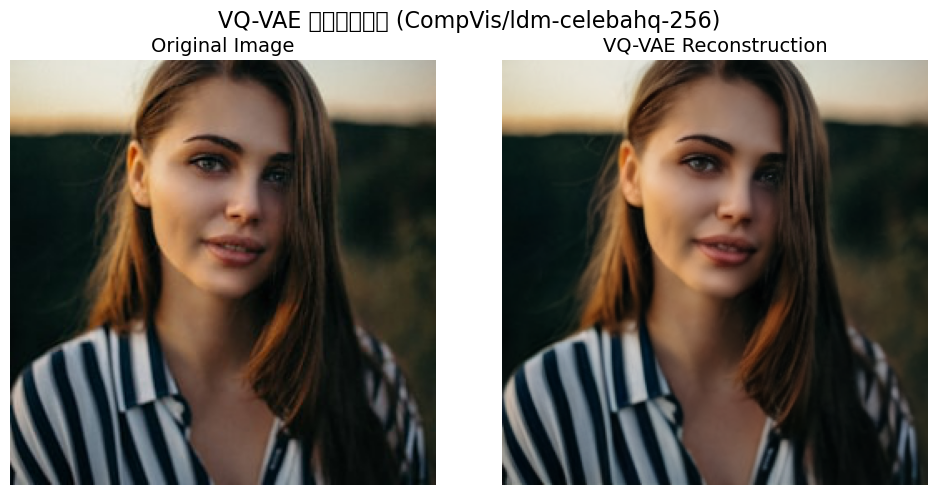


如果重建图像明显模糊，说明 VQ-VAE 本身的重建能力有限，
这会直接影响 LDM 的最终生成质量。


In [17]:
# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(test_image)
axes[0].set_title("Original Image", fontsize=14)
axes[0].axis('off')

axes[1].imshow(reconstructed)
axes[1].set_title("VQ-VAE Reconstruction", fontsize=14)
axes[1].axis('off')

plt.suptitle("VQ-VAE 重建质量测试 (CompVis/ldm-celebahq-256)", fontsize=16)
plt.tight_layout()
plt.show()

print("\n如果重建图像明显模糊，说明 VQ-VAE 本身的重建能力有限，")
print("这会直接影响 LDM 的最终生成质量。")

In [18]:
# 清理
del vqvae
torch.cuda.empty_cache()
print("完成!")

完成!
